# As first we upload our Kaggle dataset

https://www.kaggle.com/competitions/learn-ai-bbc/data

In [5]:
import pandas as pd

df = pd.read_csv("bbc-news-data.csv", sep='\t')
business = df[df.category=='business']

In [6]:
business

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...,...
505,business,506.txt,Trial begins of Spain's top banker,"The trial of Emilio Botin, the chairman of Sp..."
506,business,507.txt,UK economy ends year with spurt,The UK economy grew by an estimated 3.1% in 2...
507,business,508.txt,HealthSouth ex-boss goes on trial,The former head of US medical services firm H...
508,business,509.txt,Euro firms miss out on optimism,More than 90% of large companies around the w...


# Let's use Spacy for Named Entity Recognition
https://spacy.io/models/en

In [7]:
import spacy
import spacy.displacy as displacy

nlp = spacy.load("en_core_web_trf")

doc = nlp(business.content[99])

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

WorldCom 8 16 ORG
Bernie Ebbers 23 36 PERSON
Ebbers 141 147 PERSON
Scott Sullivan 209 223 PERSON
Sullivan 268 276 PERSON
Ebbers 398 404 PERSON
his second day 456 470 DATE
New York 493 501 GPE
Ebbers 511 517 PERSON
Sullivan 563 571 PERSON
a lot of weeks 674 688 DATE
three 709 714 CARDINAL
Ebbers 734 740 PERSON
Ebbers 874 880 PERSON
Sullivan 900 908 PERSON
2002 1001 1005 DATE
$11bn accounting 1036 1052 MONEY
Sullivan 1097 1105 PERSON
one 1107 1110 CARDINAL
six 1114 1117 CARDINAL
WorldCom 1118 1126 ORG
Sullivan 1311 1319 PERSON
Ebbers 1369 1375 PERSON
WorldCom 1408 1416 ORG
Tuesday 1518 1525 DATE
Ebbers 1529 1535 PERSON
Scott Sullivan 1581 1595 PERSON
today 1733 1738 DATE
Ebbers 1744 1750 PERSON
up to 85 years 1781 1795 DATE
about $180bn 1860 1872 MONEY
WorldCom 1876 1884 ORG
20,000 1897 1903 CARDINAL
last year 1995 2004 DATE
MCI 2025 2028 ORG


### Resources: 

* https://www.kaggle.com/competitions/learn-ai-bbc/data
* https://spacy.io/models/en
* https://huggingface.co/ProsusAI/finbert

In [8]:
displacy.serve(doc, style="ent")

C:\Users\F.Bonora\Anaconda3\envs\test\lib\site-packages\spacy\displacy\__init__.py:108: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  warnings.warn(Warnings.W011)



Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


In [12]:
spacy.explain("GPE")

'Countries, cities, states'

# Now we use a Bert model from HF, fine-tuned for financial domain
https://huggingface.co/ProsusAI/finbert

In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

get_sentiment = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

### I split the article into sentences because I want to compute sentiment for each of them

In [14]:
import re

def sentence_tokenizer(document):
    sentences = re.split(r';|(?!\d)\.(?!\d)', document)
    sentences = [i for i in sentences if not re.search(r'^\s*\n?$', i)]
    return sentences

sentence_tokenizer(business.content[99])

[' Former WorldCom chief Bernie Ebbers has denied claims that he knew accountants were doctoring the books at the firm',
 '  Speaking in court, Mr Ebbers rejected allegations he pressured ex-chief financial officer Scott Sullivan to falsify company financial statements',
 ' Mr Sullivan "made accounting decisions," he told the federal court, saying his finance chief had "a keen command of the numbers"',
 ' Mr Ebbers has denied charges of fraud and conspiracy',
 ' During his second day of questioning in the New York trial Mr Ebbers played down his working relationship with Mr Sullivan and denied he frequently met him to discuss company business when questioned by the prosecution',
 '  "In a lot of weeks, we would speak ',
 ' three or four times," Mr Ebbers said, adding that conversations about finances were rarely one-on-one and were usually discussed by a "group of people" instead',
 '  Mr Ebbers relationship to Mr Sullivan is key to the case surrounding financial corruption that led to

### Let's test the sentiment model!

In [19]:
test_sentence = sentence_tokenizer(business.content[99])[1]
test_sentence

'  Speaking in court, Mr Ebbers rejected allegations he pressured ex-chief financial officer Scott Sullivan to falsify company financial statements'

In [20]:
get_sentiment(test_sentence)

[{'label': 'negative', 'score': 0.6086190938949585}]

## Now we compute NER and sentiment for all articles

In [ ]:
results = []
c = 1

for article in business.content:
    
    start = 0
    print(c)
    c += 1
    
    doc = nlp(article)
    
    sent_tokenized_article = sentence_tokenizer(article)
    
    for sentence in sent_tokenized_article:
        
        sentiment = get_sentiment(sentence)[0]
        sentiment["sentence"] = sentence
        sentiment["entities"] = []
        
        sentence_span =  (start, len(sentence)+start)
        start +=  len(sentence)
        
        for ent in doc.ents:
        
            if ent.start_char >= sentence_span[0] and ent.end_char <= sentence_span[1]:
                
                sentiment["entities"].append((ent.label_, ent.text))
            
    
        results.append(sentiment)

In [21]:
import pickle

pklpath = "results2.pkl"

with open(pklpath, 'rb') as fin:
    results = pickle.load(fin)

In [22]:
results[0:2]

[{'label': 'positive',
  'score': 0.9515852928161621,
  'sentence': ' Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier',
  'entities': [('DATE', 'Quarterly'),
   ('GPE', 'US'),
   ('ORG', 'TimeWarner'),
   ('PERCENT', '76%'),
   ('MONEY', '$1.13bn (£600'),
   ('MONEY', 'm'),
   ('DATE', 'the three months to December'),
   ('MONEY', '639'),
   ('MONEY', 'm'),
   ('DATE', 'year-earlier')]},
 {'label': 'positive',
  'score': 0.8928447961807251,
  'sentence': '  The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales',
  'entities': [('CARDINAL', 'one'), ('ORG', 'Google')]}]

## We change the data structure: we want to aggregate the sentiment per each entity

In [39]:
from collections import Counter
import numpy as np

my_entities = ['NORP', 'ORG', 'PERSON', 'GPE']  #'LOC' 'PRODUCT' 'EVENT', 'FAC'
ner_filtered = list(set([j for i in results for j in i['entities'] if j[0] in my_entities]))


data = {ent:{} for ent in my_entities}


for sentence in results:
    for ent in sentence["entities"]:
        if ent in ner_filtered:
            try:
                data[ent[0]][ent[1]].append(sentence["label"])
            except KeyError:
                data[ent[0]][ent[1]] = [sentence["label"]]


for ent in data:
    for w in data[ent].keys():
        data[ent][w] = dict(Counter(data[ent][w]))
        
        for i in ["positive", "negative", "neutral"]:
            if i not in data[ent][w].keys():
                data[ent][w].update({i:0})

In [ ]:
import json
print(json.dumps(data["GPE"], indent=4))

# Let's represent this information with Pandas and Matplotlib

In [41]:
import pandas as pd

def json2pd(data, n):
    
    df_list = []
    for cat in data.keys():
        
        df = [[cat, k, v["negative"],v["neutral"], v["positive"], sum(v.values())] for k,v in data[cat].items()]

        df = pd.DataFrame(df, columns=["category","entity", "negative", "neutral", "positive", "total"])
        df_list.append(df.sort_values("total")) #.iloc[:-1]
        
    return pd.concat(df_list)


df = json2pd(data, 0)

In [42]:
df.head(3)

,category,entity,negative,neutral,positive,total
121,NORP,Saudi Arabian,0,1,0,1
92,NORP,the Sans bushmen,0,1,0,1
61,NORP,Communists,1,0,0,1


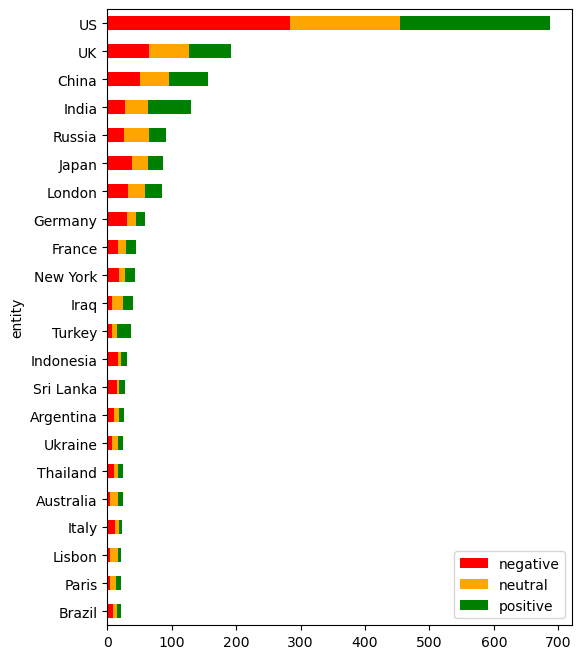

In [44]:
subdf = df[df["positive"] + df['negative'] + df['neutral'] > 20]

subdf = subdf[subdf.category=='GPE'].drop('total', axis=1)

ax = subdf.plot.barh(x="entity", stacked=True, figsize=(6, 8), color=["red", "orange", "green"])

# Let's make a BI Dashboard with Holoviz

In [ ]:
import hvplot.pandas
import holoviews as hv
import panel as pn

hv.extension('bokeh')
pn.extension('tabulator', sizing_mode="stretch_width")

idf = df.interactive()

In [ ]:
minimum_occur = pn.widgets.IntSlider(name='occurrencies', start=0, end=50, step=5)


category = pn.widgets.ToggleGroup(
    name='category',
    options=my_entities, 
    value=my_entities,
    button_type='success')


yaxis = pn.widgets.RadioButtonGroup(
    name='Y axis', 
    options=['total', 'positive', 'negative', 'neutral'],
    button_type='success'
)


ipipeline = (
    idf[(idf.total >= minimum_occur) &
             (idf.category.isin(category))]
    .groupby(['entity'])
    .mean()
    .sort_values('total', ascending=False)
    .reset_index()
    .reset_index(drop=True)
)


itable = ipipeline.pipe(pn.widgets.Tabulator, pagination='remote', page_size=10)
ihvplot = ipipeline.head(25).hvplot(x='entity', y=yaxis, line_width=6, height=400, kind='bar')

template = pn.template.FastListTemplate(
    title='Interactive DataFrame Dashboards with hvplot .interactive', 
    sidebar=[minimum_occur, 'Manufacturers', category, 'Y axis' , yaxis],
    main=[ihvplot.panel(), itable.panel()],
    accent_base_color="#88d8b0",
    header_background="#88d8b0",
)

template.show()
template.servable();